# Fitting a Neural Network to Simulation Data
Can we successfully fit a neural network to predict model parameters given our fitting parameters(alphas)? Also what are the performance metrics for such a network?


In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, create_perceptron_model
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom
from inverse_modelling_tfo.data.interpolation_function_zoo import *


In [2]:
# Load Data
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/intensity_summed_sim_data_equidistance_detector_extended.pkl')
equidistance_detector_normalization(data)
data.head(10)

,SDD,Intensity,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a
0,10,1.812894e-04,2.0,5.0,26.0,0.005,0.05
1,14,3.681103e-05,2.0,5.0,26.0,0.005,0.05
2,19,8.854552e-06,2.0,5.0,26.0,0.005,0.05
3,23,2.952029e-06,2.0,5.0,26.0,0.005,0.05
4,28,1.092797e-06,2.0,5.0,26.0,0.005,0.05
5,32,4.277922e-07,2.0,5.0,26.0,0.005,0.05
6,37,1.715046e-07,2.0,5.0,26.0,0.005,0.05
7,41,7.471047e-08,2.0,5.0,26.0,0.005,0.05
8,46,3.120305e-08,2.0,5.0,26.0,0.005,0.05
9,50,1.365238e-08,2.0,5.0,26.0,0.005,0.05


In [3]:
# fitting_param_table = get_interpolate_fit_params_custom(data, unity_at_zero_interpolation, weights=[0, 1])
fitting_param_table = get_interpolate_fit_params_custom(data, exponenet_4, weights=[1, 0])
fitting_param_table.head()

,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a,alpha0,alpha1,alpha2,alpha3
0,2.0,5.0,26.0,0.005,0.05,-15.760771,56.475355,-59.975009,7.904351
1,2.0,5.0,26.0,0.009,0.05,-16.483848,53.546342,-57.661251,7.759519
2,2.0,5.0,26.0,0.013,0.05,-17.267424,51.666028,-56.185631,7.689011
3,2.0,5.0,26.0,0.017,0.05,-18.313355,51.486330,-56.197820,7.805500
4,2.0,5.0,26.0,0.021,0.05,-19.814529,53.669168,-58.312192,8.202734


In [4]:
# Let's Try only one wavelength at a time for now - The goal is to have 2 seperate NNs for each
fitting_param_columns = list(filter(lambda X: 'alpha' in X, fitting_param_table.columns))
y_columns = ['Fetal Mu_a', "Maternal Mu_a", "Maternal Wall Thickness"]
# y_columns = ['Fetal Mu_a']
filtered_fitting_param_table = fitting_param_table[fitting_param_table['Wave Int'] == 2.0]

In [5]:
# Describe Data
# print(filtered_fitting_param_table[y_columns].describe())
# print(filtered_fitting_param_table['Fetal Mu_a'].value_counts())

# Normalize Fitting Parameters
We should make sure the mean and variance of the fitting parameters are normalized before passing them into a neural network. This way the fitting should be much more reliable/robust. Using a very simple scaling approach for this

In [6]:
x_scaler = preprocessing.StandardScaler()
filtered_fitting_param_table[fitting_param_columns] = x_scaler.fit_transform(filtered_fitting_param_table[fitting_param_columns])
y_scaler = preprocessing.StandardScaler()
filtered_fitting_param_table[y_columns] = y_scaler.fit_transform(filtered_fitting_param_table[y_columns])



np.random.seed(70)  # Set seed for consistentcy
params = {
    'batch_size': 500, 'shuffle': True, 'num_workers': 2
}
train, val = generate_data_loaders(filtered_fitting_param_table, params, fitting_param_columns, y_columns, 0.9)
# model = create_perceptron_model([3, 6, 3, 2, 1])
model = create_perceptron_model([4, 6, 6, 3])
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=6, bias=True)
  (3): ReLU()
  (4): Linear(in_features=6, out_features=3, bias=True)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Sigmoid()
)


/tmp/ipykernel_356697/1569301122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fitting_param_table[fitting_param_columns] = x_scaler.fit_transform(filtered_fitting_param_table[fitting_param_columns])
/tmp/ipykernel_356697/1569301122.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fitting_param_table[y_columns] = y_scaler.fit_transform(filtered_fitting_param_table[y_columns])


In [7]:
criterion = nn.MSELoss()
# optimizer = Adam(model.parameters(), lr=0.1)
optimizer = SGD(model.parameters(), lr=0.0018, momentum=0.9)

In [8]:
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=300)

KeyboardInterrupt: 

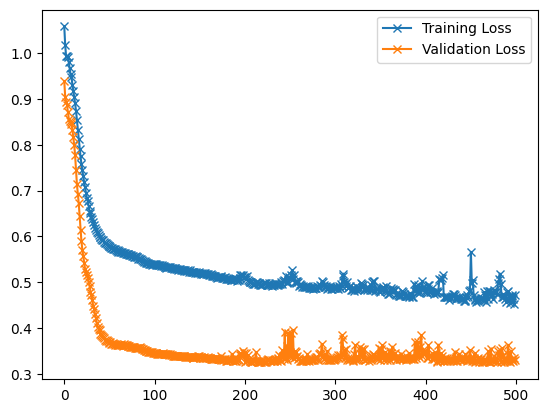

In [ ]:
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
plt.legend()

In [ ]:
# Save model
torch.save(model.state_dict(), r'../inverse_modelling_tfo/models/fetal_mu_a_model.pt')

In [ ]:
print(x_scaler.mean_)
print(x_scaler.var_)
print(y_scaler.mean_)
print(y_scaler.var_)

[ -8.36710599   9.29361004 -21.46915369   3.94492118]
[ 1258.39840231 28541.78721394 25152.15758128   578.76114821]
[ 0.17   0.027 20.   ]
[6.40000000e-03 1.90666667e-04 1.20000000e+02]
